# CAPSTONE_FINAL_PROJECT

## INTRODUCTION
### This project is all about scrutinizing a place having virtuous neighborhood with some specified criteria(as per basic needs of an individual):

### Neighborhood should have good amenities  like restaurants, parks,clubs,shopping malls, gyms nearby neighborhoods.
 
### In this project, I will be using the neighborhood & location data of Toronto from the previous assignment.Then will use Foursquare API to explore neighborhoods in Toronto city.After getting neighborhoods of toronto, i will find nearby venues with respect to neighborhoods as mentioned above. Then by using K-means clustering algorithm will cluster those venues. After that I will analyze the result with optimal value of K. Finally, with the use the Folium library we will visualize the different venues in Toronto neighborhood and their emerging clusters and will get to know aboiut all information regarding venue category, name, location, distance.

## PROBLEM STATEMENT:
### People coming from differnt countries, cities or areas firstly needs a good accommodation where his/her all basic requirements for living can be fulfilled.Obviously, as we all know after relocating to some other place every person would search such type of accomodation where he/she can live happily with good environment.So here we will find solution to accommodation problem of a person so that he/she can find best place to live with his/her personal choices of different amenities like restaurants, parks,clubs, shopping malls,gyms situated in neighborhoods.  

### For this project we will only use Toronto neighborhoods where Borough contains Toronto. Here we need to find all amenities data using foursquare API. The data should be available by Postal Code OR by Lattitude and Longitude. 
### The restaurants, parks, clubs,shopping malls, gyms information for all neighborhoods of interest in Toronto can be extracted using Foursquare. 



## TABLE OF CONTENTS

### 1. Extract data of Toronto neighborhoods from Wikipedia

### 2. Explore and clean neighborhoods dataset

### 3. Get venues(restaurants, parks, clubs, malls, gyms)

### 4. Analyze venues dataset

### 5. Cluster Venues

### 6. Examine Clusters



### Libraries imported

In [1]:
! pip install --upgrade pip
print("done")

Requirement already up-to-date: pip in ./common/.virtualenv/python3/lib/python3.5/site-packages (19.0.3)
done


In [2]:
! pip install beautifulSoup4
print ('done')

done


In [3]:
from bs4 import BeautifulSoup
print("done")

done


In [6]:
import numpy as np # data in a vectorized manner manipulation
import pandas as pd # data analsysis
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import json # JSON files manipulation
import requests # HTTP library
from bs4 import BeautifulSoup # scraping library

from sklearn.cluster import KMeans # clustering algorithm

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
# !conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## 1. Extract data of Toronto neighborhoods from Wikipedia

In [7]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

text_result = requests.get(url).text #get the entire html of the article as a str
html_parsed_result = BeautifulSoup(text_result, 'html.parser') #transform the text to html

neighborhood_info_table = html_parsed_result.find('table', class_ = 'wikitable')
neighborhood_rows = neighborhood_info_table.find_all('tr')

# extract the info ('Postcode', 'Borough', 'Neighbourhood') from the table
neighborhood_info = []
for row in neighborhood_rows:
    info = row.text.split('\n')[1:-1] # remove empty str (first and last items)
    neighborhood_info.append(info)
    
neighborhood_info[0:20]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront'],
 ['M5A', 'Downtown Toronto', 'Regent Park'],
 ['M6A', 'North York', 'Lawrence Heights'],
 ['M6A', 'North York', 'Lawrence Manor'],
 ['M7A', "Queen's Park", 'Not assigned'],
 ['M8A', 'Not assigned', 'Not assigned'],
 ['M9A', 'Etobicoke', 'Islington Avenue'],
 ['M1B', 'Scarborough', 'Rouge'],
 ['M1B', 'Scarborough', 'Malvern'],
 ['M2B', 'Not assigned', 'Not assigned'],
 ['M3B', 'North York', 'Don Mills North'],
 ['M4B', 'East York', 'Woodbine Gardens'],
 ['M4B', 'East York', 'Parkview Hill'],
 ['M5B', 'Downtown Toronto', 'Ryerson'],
 ['M5B', 'Downtown Toronto', 'Garden District']]

### transform data into pandas dataframe

In [8]:
#create a Neighborhoods dataframe
neighborhood_info[0][-1] = 'Neighborhood' # change to american spelling
neighborhood_df = pd.DataFrame(neighborhood_info[1:], columns=neighborhood_info[0])

neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


## 2. Explore and clean neighborhoods dataset

### getting dataset shape and it's column information

In [9]:
not_assigned_boroughs = neighborhood_df.index[neighborhood_df['Borough'] == 'Not assigned']
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned']
not_assigned_neighborhoods_and_borough = not_assigned_boroughs & not_assigned_neighborhoods

print('The DataFrame shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} rows with Not assigned Borough'.format(not_assigned_boroughs.shape[0]))
print('  {} rows with Not assigned Neighborhood'.format(not_assigned_neighborhoods.shape[0]))
print('  {} rows with Not assigned Neighborhood and Borough'.format(not_assigned_neighborhoods_and_borough.shape[0]),'\n')

The DataFrame shape is (288, 3) 

There are:
  180 Postal codes
  11 Boroughs
  208 Neighborhoods
  77 rows with Not assigned Borough
  78 rows with Not assigned Neighborhood
  77 rows with Not assigned Neighborhood and Borough 



### Eliminating "not assigned" values from boroughs

In [10]:
neighborhood_df.drop(neighborhood_df.index[not_assigned_boroughs], inplace=True)
neighborhood_df.reset_index(drop=True, inplace=True)

neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Not assigned
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


### replacing "not assigned values" in neighborhood with borough name

In [11]:
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned'] # run this again because the indexes on the dataframe where reset

for idx in not_assigned_neighborhoods:
    neighborhood_df['Neighborhood'][idx] = neighborhood_df['Borough'][idx]
    
neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Queen's Park
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


### after cleaning data, new dataset shape and its column information

In [12]:
print('After cleaning the DataFrame, its new shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0]))
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0]))

After cleaning the DataFrame, its new shape is (211, 3) 

There are:
  103 Postal codes
  11 Boroughs
  209 Neighborhoods


### The dataframe has 103 Postal codes but it has 211 rows, because each Postal code can present more than one neighborhood (209 in total).Therefore, the dataframe should be group by the Postal code, ending with a dataframe with 103 rows.

In [13]:
group = neighborhood_df.groupby('Postcode')
grouped_neighborhoods = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
grouped_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
grouped_df.columns = ['Postcode', 'Borough', 'Neighborhood']

grouped_df.head(10)

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


### new dataframe shape

In [14]:
print('The DataFrame shape is', grouped_df.shape)

The DataFrame shape is (103, 3)


### adding coordinates to postal codes

In [15]:
coordinates_df = pd.read_csv("Geospatial_Coordinates_capstone_week3.csv") # transform the csv file into a dataframe

print('The coordinates dataframe shape is', coordinates_df.shape)
coordinates_df.head()

The coordinates dataframe shape is (103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### join coordinates data to above neighborhood data

In [16]:

postcodes_with_coordinates_df = grouped_df.join(coordinates_df.set_index('Postal Code'), on='Postcode')

postcodes_with_coordinates_df.head(10)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


### Next will get only the neighborhoods that contain Toronto in the Borough.

In [17]:
neighborhood_toronto = postcodes_with_coordinates_df[postcodes_with_coordinates_df['Borough'].str.contains("Toronto")].sort_values('Postcode').reset_index(drop=True)
neighborhood_toronto

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
7,M4S,Central Toronto,Davisville,43.704324,-79.388790
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


### after observing above dataset we just found total 38 no. of postcodes which are in toronto only

### getting geographical coordinates of toronto 

In [18]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="coursera-capstone-project")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto City are 43.653963, -79.387207.


### create map of toronto using latitude and longitude values

In [19]:
map = folium.Map(location=[43.6532,-79.3832], zoom_start=12)

for location in neighborhood_toronto.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=5,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=100,
        popup=label,
        location=[location[-2], location[-1]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

### we got a map with highlighted points which are showing information of each postcode whiel clicking on it regarding its borough name, neighborhood name. 

### scatter plot for postcode venues in toronto only.

In [20]:
! pip install matplotlib
print("done")

done


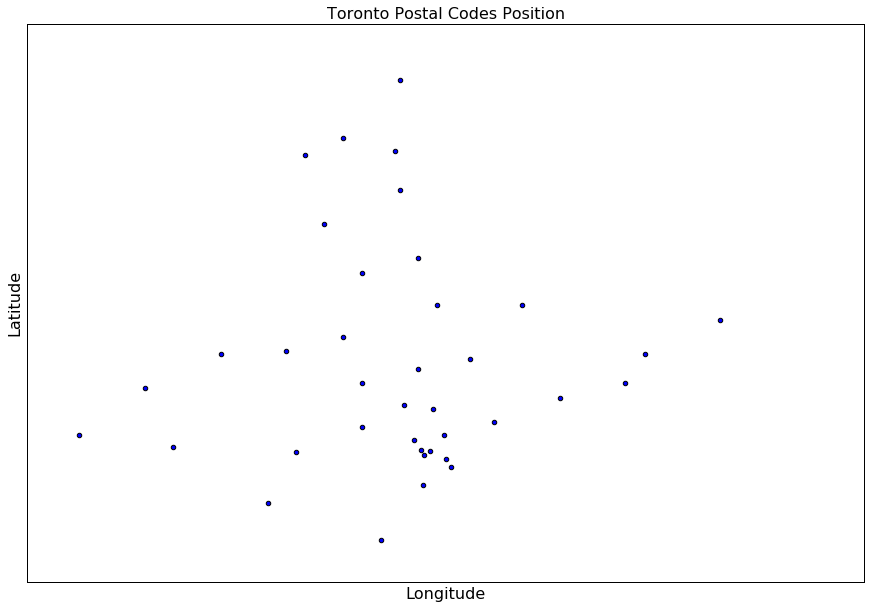

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

X = neighborhood_toronto[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

### To define the radius we have to use foursquare API & it's necessary to find the closest points for each postcode

In [22]:
! pip install geopy
print("done")

done


In [23]:
from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

### To explore the distance function, the closest postcode to the first example in the dataframe is found

In [24]:
coordinates = neighborhood_toronto[['Latitude', 'Longitude']]

distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points

,Longitude,Latitude
0,-79.293031,43.676357
2,-79.315572,43.668999


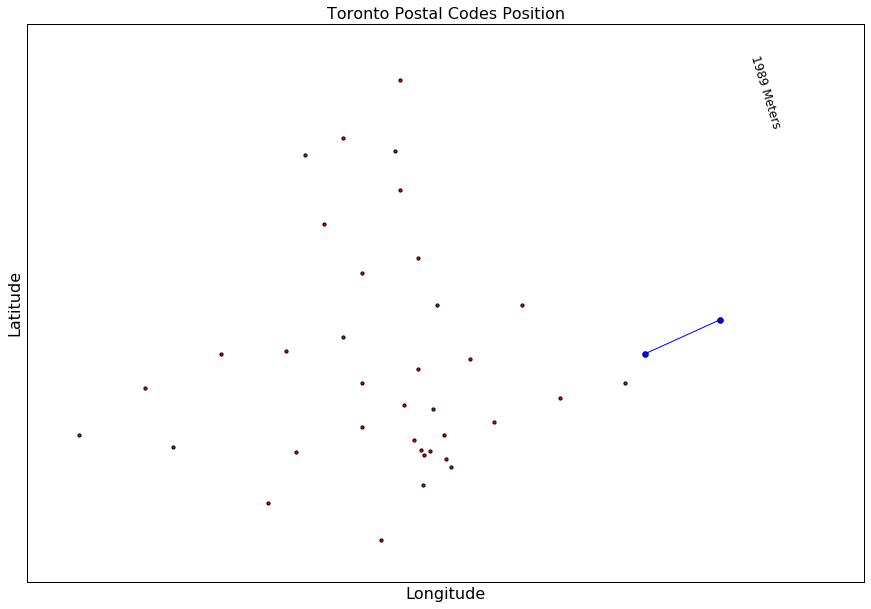

In [25]:
fig = plt.figure(figsize=(15,10))
scatter_plot = fig.add_subplot(111)
scatter_plot.scatter(X['Longitude'],X['Latitude'], s=10, c='r', marker="o")
scatter_plot.plot(close_points['Longitude'], close_points['Latitude'], c='b', marker="o")

# plt.legend(loc='upper left');
scatter_plot.annotate('{} Meters'.format(distance),
            xy=(.859, .912), xycoords='figure fraction',
            ha='left', va='top', rotation=-73,
            fontsize=12)

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)

plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

### A distance column is added to the DataFrame and is used as the radius cover for each postcode. So let's insert one more column of distance to above dataframe.

In [26]:
from math import isnan

for lat, lng, idx in zip(neighborhood_toronto['Latitude'], neighborhood_toronto['Longitude'], neighborhood_toronto.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    neighborhood_toronto.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping 
neighborhood_toronto.head(40)

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,994.0
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,896.0
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,423.0
3,M4M,East Toronto,Studio District,43.659526,-79.340923,799.0
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,851.0
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,472.0
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,496.0
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,472.0
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,601.0
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,701.0


### The map is plotted using different radius for each postal code. Now not only overlapping will be avoided but more area of the city will be covered. Consequently, more venues will be retrieved

In [27]:
map = folium.Map(location=[latitude,longitude], zoom_start=12)

for location in neighborhood_toronto.itertuples(): #iterate each row of the dataframe
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-3], location[-2]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map) 
    folium.Circle(
        radius=location[-1],
        popup=label,
        location=[location[-3], location[-2]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map) 
    
map

###  Next thing to do is explore each Postcode to get venues using the Foursquare API. For that, the credential must be declared (i.e. foursquare id & foursquare secret)

### In order to get the venues in the perimeter of each Postal code, it is necessary to get the geographical coordinates (lat and lng) of each one of those and add them to the dataframe

In [28]:
CLIENT_ID = '50JJ5W0ZPTP41GMCYUWJRO33GXUHUYBP0XYKR335P2VPNAN1' # your Foursquare ID
CLIENT_SECRET = '03SNEIFDNMFKFHDDYR3NA4VJSJYHCNLAQV2DPK55ENXK0D2W' # your Foursquare Secret
VERSION = '20181102'

### information regarding no. of neighborhoods, no. of boroughs, no. of postcodes along with their lat, long, distance

In [29]:
neighborhood_toronto.nunique()

Postcode        38
Borough          4
Neighborhood    38
Latitude        38
Longitude       33
Distance        26
dtype: int64

In [30]:
neighborhood_toronto['Neighborhood'].nunique()

38

## 3.Get all venues in each Neighborhood 

### To explore the data returned by the Foursquare API, a maximum of 100 venues from the first postcode are requested in a radius of 500 meters.

In [31]:
def format_url(lat, lng, radius=500, limit=100):
    return 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 
        lat, lng, VERSION, radius, limit)

In [32]:
first_postcode = neighborhood_toronto.iloc[2, :]
url = format_url(first_postcode['Latitude'], first_postcode['Longitude'], first_postcode['Distance'])

url

'https://api.foursquare.com/v2/venues/explore?client_id=50JJ5W0ZPTP41GMCYUWJRO33GXUHUYBP0XYKR335P2VPNAN1&client_secret=03SNEIFDNMFKFHDDYR3NA4VJSJYHCNLAQV2DPK55ENXK0D2W&ll=43.6689985,-79.31557159999998&v=20181102&radius=423.0&limit=100'

In [33]:
#function to get batch of venues as a dataframe
def get_venues(url):
    results = requests.get(url).json()
    venues = results['response']['groups'][0]['items']
    return json_normalize(venues)

In [34]:
venues_df = get_venues(url)

venues_df.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.events.count,venue.events.summary,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups
0,0,"[{'reasonName': 'globalInteractionReason', 'ty...",e-0-4b942922f964a520f16b34e3-0,"[{'primary': True, 'shortName': 'Fish & Chips'...",NaN,NaN,4b942922f964a520f16b34e3,73 Coxwell Ave.,CA,Toronto,Canada,Dundas St & Coxwell St,129,"[73 Coxwell Ave. (Dundas St & Coxwell St), Tor...","[{'lng': -79.31713935234417, 'lat': 43.6687233...",43.668723,-79.317139,M4L 3A7,ON,British Style Fish & Chips,0,[]
1,0,"[{'reasonName': 'globalInteractionReason', 'ty...",e-0-4c1169396e5dc9b61b10b02d-1,"[{'primary': True, 'shortName': 'Burgers', 'ic...",NaN,NaN,4c1169396e5dc9b61b10b02d,1636 Queen St. E,CA,Toronto,Canada,btwn Coxwell Ave. & Kingston Rd.,265,[1636 Queen St. E (btwn Coxwell Ave. & Kingsto...,"[{'lng': -79.31553079617778, 'lat': 43.6666115...",43.666612,-79.315531,M4L 1G3,ON,The Burger's Priest,0,[]
2,0,"[{'reasonName': 'globalInteractionReason', 'ty...",e-0-4ade390ff964a5200e7421e3-2,"[{'primary': True, 'shortName': 'Gym', 'icon':...",NaN,NaN,4ade390ff964a5200e7421e3,1661 Queen St East,CA,Toronto,Canada,at Kingston Rd,305,"[1661 Queen St East (at Kingston Rd), Toronto ...","[{'lng': -79.31273345707406, 'lat': 43.6671714...",43.667171,-79.312733,NaN,ON,System Fitness,0,[]
3,0,"[{'reasonName': 'globalInteractionReason', 'ty...",e-0-59172e0169e77b035cdbe7bd-3,"[{'primary': True, 'shortName': 'Ice Cream', '...",NaN,NaN,59172e0169e77b035cdbe7bd,NaN,CA,Toronto,Canada,NaN,296,"[Toronto ON M4L 1G6, Canada]","[{'lng': -79.312831, 'lat': 43.667222, 'label'...",43.667222,-79.312831,M4L 1G6,ON,Brett's Ice Cream,0,[]
4,0,"[{'reasonName': 'globalInteractionReason', 'ty...",e-0-4ba0153bf964a520995837e3-4,"[{'primary': True, 'shortName': 'Italian', 'ic...",NaN,NaN,4ba0153bf964a520995837e3,1646 Queen St. E,CA,Toronto,Canada,"at Eastern Ave,",263,"[1646 Queen St. E (at Eastern Ave,), Toronto O...","[{'lng': -79.31520351125722, 'lat': 43.6666452...",43.666645,-79.315204,M4L 1G3,ON,Casa di Giorgio,0,[]


### In this case, the relevant information is venue.categories, venue.location.lat, venue.location.lng and venue.name.So just keep this information and drop other columns

In [35]:
#function to clean the venues dataframe
def clean_df(df):
    relevant_columns = [ 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.name']
    clean_df = df.loc[:,relevant_columns]

    #rename columns
    clean_df.columns = ['Category', 'Lat', 'Lng', 'Name']
    return clean_df 

venues_df = clean_df(venues_df)
venues_df.head()

,Category,Lat,Lng,Name
0,"[{'primary': True, 'shortName': 'Fish & Chips'...",43.668723,-79.317139,British Style Fish & Chips
1,"[{'primary': True, 'shortName': 'Burgers', 'ic...",43.666612,-79.315531,The Burger's Priest
2,"[{'primary': True, 'shortName': 'Gym', 'icon':...",43.667171,-79.312733,System Fitness
3,"[{'primary': True, 'shortName': 'Ice Cream', '...",43.667222,-79.312831,Brett's Ice Cream
4,"[{'primary': True, 'shortName': 'Italian', 'ic...",43.666645,-79.315204,Casa di Giorgio


In [36]:

venues_df.loc[0, 'Category']

[{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fishandchips_',
   'suffix': '.png'},
  'id': '4edd64a0c7ddd24ca188df1a',
  'name': 'Fish & Chips Shop',
  'pluralName': 'Fish & Chips Shops',
  'primary': True,
  'shortName': 'Fish & Chips'}]

### It is necessary to extract the Category (shortName) of the JSON data

In [37]:
#function that extract the category name
def get_category_name(row):
    category_json = row['Category']
    try:
        return category_json[0]['name']
    except:        
        return None

venues_df['Category'] = venues_df.apply(get_category_name, axis=1)

venues_df

,Category,Lat,Lng,Name
0,Fish & Chips Shop,43.668723,-79.317139,British Style Fish & Chips
1,Burger Joint,43.666612,-79.315531,The Burger's Priest
2,Gym,43.667171,-79.312733,System Fitness
3,Ice Cream Shop,43.667222,-79.312831,Brett's Ice Cream
4,Italian Restaurant,43.666645,-79.315204,Casa di Giorgio
5,Pub,43.667319,-79.312656,Murphy's Law
6,Liquor Store,43.666732,-79.314966,LCBO
7,Sushi Restaurant,43.666684,-79.316614,O Sushi
8,Steakhouse,43.666348,-79.316854,The Tulip Steakhouse
9,Pet Store,43.666979,-79.314665,Pet Valu


### Next step is to get venues for each postal code

In [38]:
#function to construct the dataframe with all the venues (max 100 venues per postal code)
def get_all_venues(neighborhood, lat, lng, radius):
    venues_list=[]
    for neighborhood, lat, lng, radius in zip(neighborhood, lat, lng, radius):
        url= format_url(lat, lng, radius)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            neighborhood,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name'])
            for v in results])
    all_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    all_venues.columns = ['Neighborhood',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Category'
                  ]
    
    return all_venues

In [39]:
all_venues = get_all_venues(neighborhood_toronto['Neighborhood'], neighborhood_toronto['Latitude'], neighborhood_toronto['Longitude'], neighborhood_toronto['Distance'])

print('The total number of venues in toronto returned is ', all_venues.shape[0])

all_venues.tail(10)

The total number of venues in toronto returned is  1612


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
1602,Business Reply Mail Processing Centre 969 Eastern,The Green Wood,43.664728,-79.324117,Restaurant
1603,Business Reply Mail Processing Centre 969 Eastern,Chick-n-Joy,43.665181,-79.321403,Fast Food Restaurant
1604,Business Reply Mail Processing Centre 969 Eastern,East End Garden Centre & Hardware,43.664555,-79.324598,Garden Center
1605,Business Reply Mail Processing Centre 969 Eastern,Amin Car Repair Garage,43.663544,-79.320130,Auto Workshop
1606,Business Reply Mail Processing Centre 969 Eastern,The Ashbridge Estate,43.664691,-79.321805,Garden
1607,Business Reply Mail Processing Centre 969 Eastern,TTC Russell Division,43.664908,-79.322560,Light Rail Station
1608,Business Reply Mail Processing Centre 969 Eastern,Jonathan Ashbridge Park,43.664702,-79.319898,Park
1609,Business Reply Mail Processing Centre 969 Eastern,The Ten Spot,43.664815,-79.324213,Spa
1610,Business Reply Mail Processing Centre 969 Eastern,Toronto Yoga Mamas,43.664824,-79.324335,Yoga Studio
1611,Business Reply Mail Processing Centre 969 Eastern,TTC Stop #03049,43.664470,-79.325145,Light Rail Station


### above data shows that there are total 1609 venues available in toronto neighborhoods that include above mentioned amenities which we need to find out and also others. so now we have to extract only those from 1609 which we need.

### firsly check whether all postcodes contain venues or not

In [40]:
print('Total Toronto postcodes:', neighborhood_toronto['Neighborhood'].shape[0])
print('Total Toronto postcodes with venues:', all_venues['Neighborhood'].unique().shape[0])

Total Toronto postcodes: 38
Total Toronto postcodes with venues: 37


### Therefore now we can say that out of 38 uniques postcodes of toronto, 37 no. of postcodes have venues in toronto. These 37 no. of postcodes in toronto have total 1609 venues. Bue we have to find out only those venues as mentioned above out of 1609 i.e. restaurants, parks, clubs, malls, gyms & drop others

### Following shown postcode is that postcode which have no venue

In [41]:

neighborhood_diff = np.setdiff1d(neighborhood_toronto['Neighborhood'].values,all_venues['Neighborhood'].unique())
neighborhood_toronto[neighborhood_toronto['Neighborhood']==neighborhood_diff[0]]

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance
16,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,111.0


## 4. Analyze venues data

### Total no. of restaurants in dataframe of toronto are as follows:

In [92]:
all_venues_restaurants =all_venues[all_venues['Venue Category'].str.contains("Restaurant")].sort_values('Neighborhood').reset_index(drop=True)
print("Total no. of restaurants in Toronto:", all_venues_restaurants.shape[0])
all_venues_restaurants.head()

Total no. of restaurants in Toronto: 375


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Adelaide, King, Richmond",Ninki Izakaya,43.650228,-79.384863,Japanese Restaurant
1,"Adelaide, King, Richmond",Tachi,43.650364,-79.383906,Sushi Restaurant
2,"Adelaide, King, Richmond",Rosalinda,43.650252,-79.385156,Vegetarian / Vegan Restaurant
3,"Adelaide, King, Richmond",Estiatorio Volos,43.650329,-79.384533,Greek Restaurant
4,"Brockton, Exhibition Place, Parkdale Village",Vogue Supper Club,43.636951,-79.425446,Restaurant


In [93]:
all_venues_restaurants.shape

(375, 5)

In [91]:
r=all_venues_restaurants["Neighborhood"].unique
r

<bound method Series.unique of 0                               Adelaide, King, Richmond
1                               Adelaide, King, Richmond
2                               Adelaide, King, Richmond
3                               Adelaide, King, Richmond
4           Brockton, Exhibition Place, Parkdale Village
5           Brockton, Exhibition Place, Parkdale Village
6           Brockton, Exhibition Place, Parkdale Village
7           Brockton, Exhibition Place, Parkdale Village
8           Brockton, Exhibition Place, Parkdale Village
9           Brockton, Exhibition Place, Parkdale Village
10          Brockton, Exhibition Place, Parkdale Village
11          Brockton, Exhibition Place, Parkdale Village
12          Brockton, Exhibition Place, Parkdale Village
13          Brockton, Exhibition Place, Parkdale Village
14          Brockton, Exhibition Place, Parkdale Village
15          Brockton, Exhibition Place, Parkdale Village
16          Brockton, Exhibition Place, Parkdale Village


### Total no. of parks in dataframe of toronto are as follows:

In [45]:
all_venues_parks =all_venues[all_venues['Venue Category'].str.contains("Park")].sort_values('Neighborhood').reset_index(drop=True)
print("Total no. of parks in Toronto:", all_venues_parks.shape[0])
all_venues_parks.head()

Total no. of parks in Toronto: 44


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Adelaide, King, Richmond",Osgoode Hall Park,43.651105,-79.386269,Park
1,"Brockton, Exhibition Place, Parkdale Village",Kiddie Midway,43.633469,-79.422751,Theme Park
2,Business Reply Mail Processing Centre 969 Eastern,Jonathan Ashbridge Park,43.664702,-79.319898,Park
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",Little Norway Park,43.634871,-79.398474,Park
4,"Cabbagetown, St. James Town",Rosedale Ravine,43.672152,-79.367150,Park


In [94]:
all_venues_parks.shape

(44, 5)

### Total no. of clubs in dataframe of toronto are as follows:

In [46]:
all_venues_clubs = all_venues[all_venues['Venue Category'].str.contains("Club")].sort_values('Neighborhood').reset_index(drop=True)
print("Dataset shape for all clubs in Toronto:",all_venues_clubs.shape[0])
all_venues_clubs.head()

Dataset shape for all clubs in Toronto: 4


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Chinatown, Grange Park, Kensington Market",Poetry Jazz Cafe,43.654975,-79.402371,Jazz Club
1,Church and Wellesley,Flash,43.664319,-79.380190,Strip Club
2,Studio District,The Opera House,43.658904,-79.348744,Rock Club
3,The Beaches,Beaches International Jazz Festival,43.669992,-79.300348,Jazz Club


### Total no. of malls in dataframe of toronto are as follows:

In [47]:
all_venues_malls = all_venues[all_venues['Venue Category'].str.contains("Mall")].sort_values('Neighborhood').reset_index(drop=True)
print("Dataset shape for all malls in Toronto:",all_venues_malls.shape[0])
all_venues_malls.head()

Dataset shape for all malls in Toronto: 1


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Harbourfront East, Toronto Islands, Union Station",Queen's Quay Terminal,43.638318,-79.380413,Shopping Mall


### Total no. of gyms in dataframe of toronto are as follows:

In [48]:
all_venues_gyms = all_venues[all_venues['Venue Category'].str.contains("Gym")].sort_values('Neighborhood').reset_index(drop=True)
print("Dataset shape for all gyms in Toronto:",all_venues_gyms.shape[0])
all_venues_gyms.head()

Dataset shape for all gyms in Toronto: 36


,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Brockton, Exhibition Place, Parkdale Village",Reebok Crossfit Liberty Village,43.637036,-79.424802,Gym
1,"Cabbagetown, St. James Town",The 500 on Sherbourne's Fitness Gym,43.667601,-79.375471,Gym / Fitness Center
2,Christie,Vive Fitness 24-7,43.672645,-79.416035,Gym
3,Church and Wellesley,YMCA,43.662753,-79.384849,Gym
4,Church and Wellesley,Hone Fitness,43.667484,-79.385510,Gym


### In order to get a better sense of data, the best way is clustering the venues and analyzing to get insights from data of venues.

### no. of all venues as per their neighborhoods column along with distance

In [49]:
venues_in_neighborhood = all_venues.groupby('Neighborhood').count()
venues_in_neighborhood = pd.DataFrame(list(zip(venues_in_neighborhood.index, venues_in_neighborhood['Venue'])), 
                                  columns=['Neighborhood', '# of venues']).set_index('Neighborhood').join(neighborhood_toronto[['Neighborhood','Distance']].set_index('Neighborhood'), on='Neighborhood').reset_index()
venues_in_neighborhood['Distance'] = np.int64(venues_in_neighborhood['Distance'])
venues_in_neighborhood.loc[len(venues_in_neighborhood.index)] = ['M5E', 0, 111] #add M5E (neighborhood without venues) with zero as # of venues

venues_in_neighborhood.head(10)

,Neighborhood,# of venues,Distance
0,"Adelaide, King, Richmond",17,150
1,"Brockton, Exhibition Place, Parkdale Village",64,703
2,Business Reply Mail Processing Centre 969 Eastern,15,423
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",29,834
4,"Cabbagetown, St. James Town",69,633
5,Central Bay Street,59,342
6,"Chinatown, Grange Park, Kensington Market",100,527
7,Christie,26,701
8,Church and Wellesley,82,471
9,"Commerce Court, Victoria Hotel",12,91


In [50]:
venues_in_neighborhood.describe()

,# of venues,Distance
count,38.000000,38.000000
mean,42.421053,539.631579
std,33.844343,260.563985
min,0.000000,75.000000
25%,9.750000,370.500000
50%,32.000000,564.000000
75%,68.750000,730.750000
max,100.000000,994.000000


### The minimum amount of venues present as per neighborhood is 0, as we add M5E, and the maximum is 100, expected given the limit of venues set on the request sent to the Foursquare API. 
### 50% of the venues presents 33 nos. or less nos. of venues.If me move towards 75% of venues it reaches level of 67 no. of venues.

###  all venues Frequency Distribution:



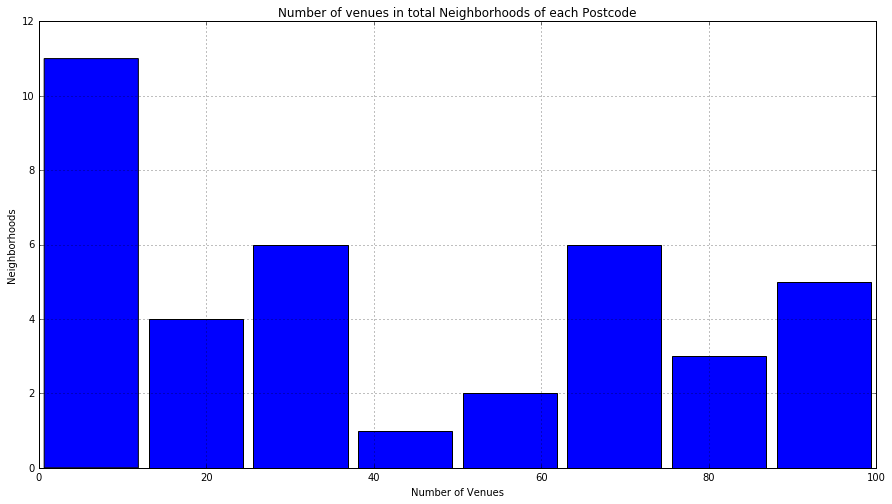

In [51]:
venues_in_neighborhood["# of venues"].hist(bins=8, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Venues')
plt.ylabel('Neighborhoods')
plt.title('Number of venues in total Neighborhoods of each Postcode')
plt.show()

###  All venues densities and their plots:


### 1.Restaurants density table and plot 
### 2. Parks density table and plot 
### 3. Clubs density table and plot 
### 4. Malls density table and plot 
### 5. Gyms density table and plot 

### density of each venue in all neighborhoods as per postcode

In [52]:
density_restaurants_in_neighborhood = all_venues_restaurants.groupby('Neighborhood').count()

density_restaurants_in_neighborhood = pd.DataFrame(list(zip(density_restaurants_in_neighborhood.index, density_restaurants_in_neighborhood['Venue'])), 
                                  columns=['Neighborhood', 'Density']).set_index('Neighborhood').join(neighborhood_toronto[['Neighborhood','Distance']].set_index('Neighborhood'), on='Neighborhood').reset_index()
density_restaurants_in_neighborhood['Density'] = np.int64(density_restaurants_in_neighborhood['Density']/(density_restaurants_in_neighborhood['Distance']/1000)) #distance in km
density_restaurants_in_neighborhood.loc[len(venues_in_neighborhood.index)] = ['M5E', 0, 111] #add M5E (postcode without venues) with zero as density

density_restaurants_in_neighborhood.head(10)

,Neighborhood,Density,Distance
0,"Adelaide, King, Richmond",26,150.0
1,"Brockton, Exhibition Place, Parkdale Village",21,703.0
2,Business Reply Mail Processing Centre 969 Eastern,4,423.0
3,"Cabbagetown, St. James Town",23,633.0
4,Central Bay Street,49,342.0
5,"Chinatown, Grange Park, Kensington Market",62,527.0
6,Christie,4,701.0
7,Church and Wellesley,55,471.0
8,"Commerce Court, Victoria Hotel",32,91.0
9,Davisville,21,472.0


In [53]:
density_restaurants_in_neighborhood[['Density']].describe()

,Density
count,33.000000
mean,22.484848
std,17.297256
min,0.000000
25%,9.000000
50%,21.000000
75%,32.000000
max,62.000000


### The minimum amount of restaurants present as per group of neighborhood in each postcode is 0, as we add M5E, and the maximum is 58
### 50% of the venues presents 20 no. of restaurants or less.If me move towards 75% of venues it reaches level of 31 no. of restaurants. approx.

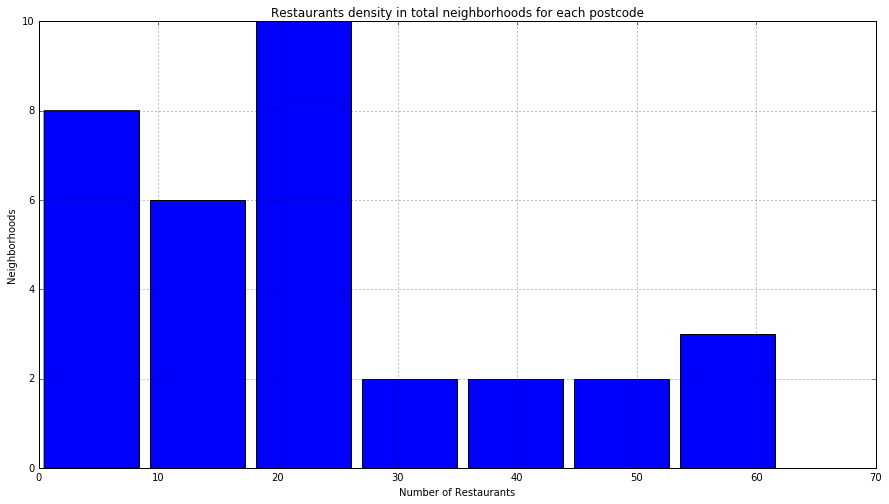

In [54]:
density_restaurants_in_neighborhood['Density'].hist(bins=7, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Restaurants')
plt.ylabel('Neighborhoods')
plt.title('Restaurants density in total neighborhoods for each postcode')
plt.show()

In [55]:
density_parks_in_neighborhood = all_venues_parks.groupby('Neighborhood').count()

density_parks_in_neighborhood = pd.DataFrame(list(zip(density_parks_in_neighborhood.index, density_parks_in_neighborhood['Venue'])), 
                                  columns=['Neighborhood', 'Density']).set_index('Neighborhood').join(neighborhood_toronto[['Neighborhood','Distance']].set_index('Neighborhood'), on='Neighborhood').reset_index()
density_parks_in_neighborhood['Density'] = np.int64(density_parks_in_neighborhood['Density']/(density_parks_in_neighborhood['Distance']/1000)) #distance in km
density_parks_in_neighborhood.loc[len(all_venues_parks.index)] = ['M5E', 0, 111] #add M5E (neighborhood without venues) with zero as density

density_parks_in_neighborhood.head(10)

,Neighborhood,Density,Distance
0,"Adelaide, King, Richmond",6,150.0
1,"Brockton, Exhibition Place, Parkdale Village",1,703.0
2,Business Reply Mail Processing Centre 969 Eastern,2,423.0
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",1,834.0
4,"Cabbagetown, St. James Town",6,633.0
5,Central Bay Street,2,342.0
6,"Chinatown, Grange Park, Kensington Market",1,527.0
7,Christie,4,701.0
8,Church and Wellesley,2,471.0
9,Davisville,2,472.0


In [56]:
density_parks_in_neighborhood[['Density']].describe()

,Density
count,27.000000
mean,2.407407
std,1.550664
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,6.000000


### The minimum amount of parks present as per group of neighborhood in each postcode is 0, as we add M5E, and the maximum is 8
### 50% of the venues presents 2 no. of parks or less.If me move towards 75% of parks it reaches level of 3 no. of parks. approx.

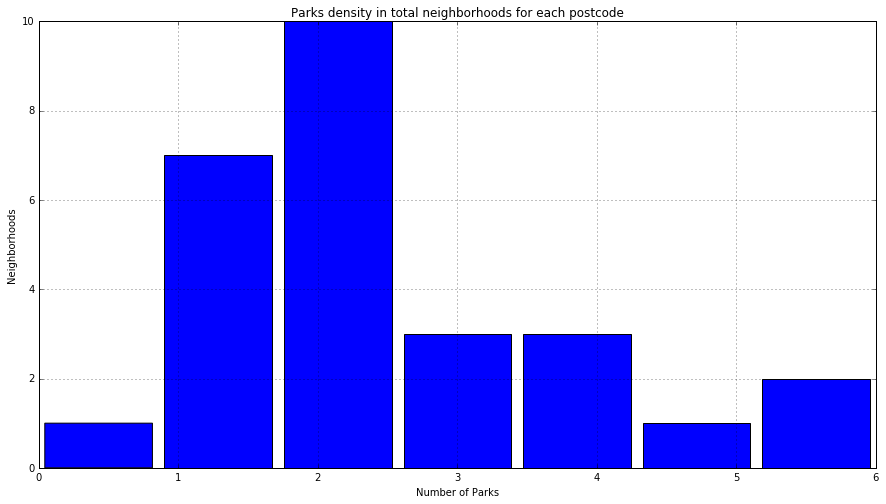

In [57]:
density_parks_in_neighborhood['Density'].hist(bins=7, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Parks')
plt.ylabel('Neighborhoods')
plt.title('Parks density in total neighborhoods for each postcode')
plt.show()

In [58]:
density_clubs_in_neighborhood = all_venues_parks.groupby('Neighborhood').count()

density_clubs_in_neighborhood = pd.DataFrame(list(zip(density_clubs_in_neighborhood.index, density_clubs_in_neighborhood['Venue'])), 
                                  columns=['Neighborhood', 'Density']).set_index('Neighborhood').join(neighborhood_toronto[['Neighborhood','Distance']].set_index('Neighborhood'), on='Neighborhood').reset_index()
density_clubs_in_neighborhood['Density'] = np.int64(density_clubs_in_neighborhood['Density']/(density_clubs_in_neighborhood['Distance']/1000)) #distance in km
density_clubs_in_neighborhood.loc[len(all_venues_clubs.index)] = ['M5E', 0, 111] #add M5E (neighborhood without venues) with zero as density

density_clubs_in_neighborhood.head(10)

,Neighborhood,Density,Distance
0,"Adelaide, King, Richmond",6,150.0
1,"Brockton, Exhibition Place, Parkdale Village",1,703.0
2,Business Reply Mail Processing Centre 969 Eastern,2,423.0
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",1,834.0
4,M5E,0,111.0
5,Central Bay Street,2,342.0
6,"Chinatown, Grange Park, Kensington Market",1,527.0
7,Christie,4,701.0
8,Church and Wellesley,2,471.0
9,Davisville,2,472.0


In [59]:
density_clubs_in_neighborhood[['Density']].describe()

,Density
count,26.000000
mean,2.269231
std,1.401647
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,6.000000


### The minimum amount of clubs present as per group of neighborhood in each postcode is 0, as we add M5E, and the maximum is 8
### 50% of the venues presents 2 no. of clubs or less.If me move towards 75% of clubs it reaches level of 3 no. of clubs. approx.

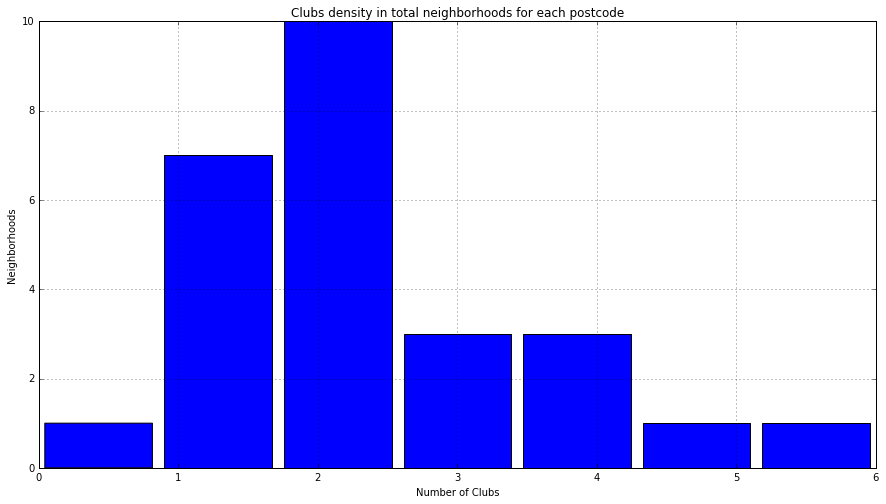

In [60]:
density_clubs_in_neighborhood['Density'].hist(bins=7, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Clubs')
plt.ylabel('Neighborhoods')
plt.title('Clubs density in total neighborhoods for each postcode')
plt.show()

In [61]:
density_malls_in_neighborhood = all_venues_malls.groupby('Neighborhood').count()

density_malls_in_neighborhood = pd.DataFrame(list(zip(density_malls_in_neighborhood.index, density_malls_in_neighborhood['Venue'])), 
                                  columns=['Neighborhood', 'Density']).set_index('Neighborhood').join(neighborhood_toronto[['Neighborhood','Distance']].set_index('Neighborhood'), on='Neighborhood').reset_index()
density_malls_in_neighborhood['Density'] = np.int64(density_malls_in_neighborhood['Density']/(density_malls_in_neighborhood['Distance']/1000)) #distance in km
density_malls_in_neighborhood.loc[len(all_venues_malls.index)] = ['M5E', 0, 111] #add M5E (neighborhood without venues) with zero as density

density_malls_in_neighborhood.head(10)

,Neighborhood,Density,Distance
0,"Harbourfront East, Toronto Islands, Union Station",2,353.0
1,M5E,0,111.0


In [62]:
density_malls_in_neighborhood[['Density']].describe()

,Density
count,2.000000
mean,1.000000
std,1.414214
min,0.000000
25%,0.500000
50%,1.000000
75%,1.500000
max,2.000000


### The minimum amount of malls present as per group of neighborhood in each postcode is 0, as we add M5E, and the maximum is 2
### 50% of the venues presents 1 no. of malls or less.If me move towards 75% of malls it reaches level of 2 no. of malls approx.

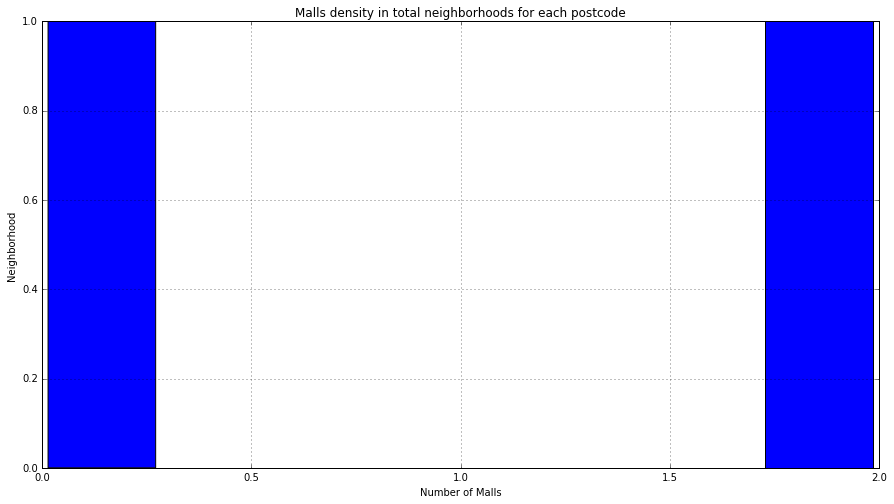

In [63]:
density_malls_in_neighborhood['Density'].hist(bins=7, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Malls')
plt.ylabel('Neighborhood')
plt.title('Malls density in total neighborhoods for each postcode')
plt.show()

In [64]:
density_gyms_in_neighborhood= all_venues_gyms.groupby('Neighborhood').count()

density_gyms_in_neighborhood = pd.DataFrame(list(zip(density_gyms_in_neighborhood.index, density_gyms_in_neighborhood['Venue'])), 
                                  columns=['Neighborhood', 'Density']).set_index('Neighborhood').join(neighborhood_toronto[['Neighborhood','Distance']].set_index('Neighborhood'), on='Neighborhood').reset_index()
density_gyms_in_neighborhood['Density'] = np.int64(density_gyms_in_neighborhood['Density']/(density_gyms_in_neighborhood['Distance']/1000)) #distance in km
density_gyms_in_neighborhood.loc[len(all_venues_clubs.index)] = ['M5E', 0, 111] #add M5E (neighborhood without venues) with zero as density

density_gyms_in_neighborhood.head(10)

,Neighborhood,Density,Distance
0,"Brockton, Exhibition Place, Parkdale Village",1,703.0
1,"Cabbagetown, St. James Town",1,633.0
2,Christie,1,701.0
3,Church and Wellesley,4,471.0
4,M5E,0,111.0
5,Davisville,2,472.0
6,Davisville North,2,472.0
7,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",2,701.0
8,"Design Exchange, Toronto Dominion Centre",13,75.0
9,"Dovercourt Village, Dufferin",3,792.0


In [65]:
density_gyms_in_neighborhood[['Density']].describe()

,Density
count,24.000000
mean,2.500000
std,2.718695
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,13.000000


### The minimum amount of gyms present as per group of neighborhood in each postcode is 0, as we add M5E, and the maximum is 13
### 50% of the venues presents 2 no. of gyms or less.If me move towards 75% of gyms it reaches level of 3 no. of gyms approx.

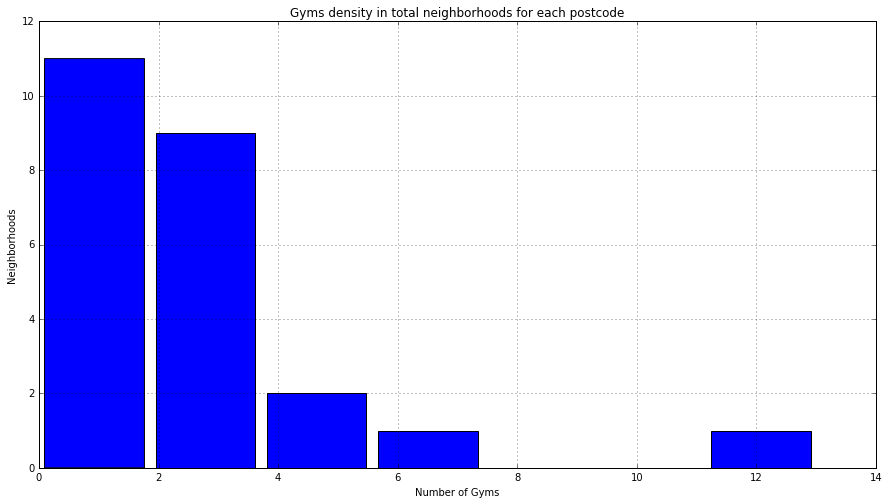

In [66]:
density_gyms_in_neighborhood['Density'].hist(bins=7, figsize=(15,8),zorder=2, rwidth=0.9)

plt.xlabel('Number of Gyms')
plt.ylabel('Neighborhoods')
plt.title('Gyms density in total neighborhoods for each postcode')
plt.show()

## 5. Cluster Venues as per their neighborhoods in each postcode

### 1. cluster restaurants
### 2. cluster parks
### 3. cluster clubs
### 4. cluster malls
### 5. cluster gyms


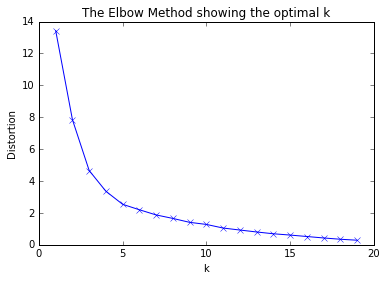

In [67]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,20)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(density_restaurants_in_neighborhood['Density'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(density_restaurants_in_neighborhood['Density'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / density_restaurants_in_neighborhood['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### optimal value of k for restaurants comes out to be 10

In [68]:
num_clusters = 10

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 12)
k_means.fit(density_restaurants_in_neighborhood['Density'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[4 7 0 7 8 6 0 3 1 7 7 4 0 2 0 2 8 2 7 0 9 5 7 2 3 9 5 7 5 2 5 1 0]


In [69]:
density_restaurants_in_neighborhood['Cluster'] = k_means.labels_
density_restaurants_in_neighborhood.head(10)

,Neighborhood,Density,Distance,Cluster
0,"Adelaide, King, Richmond",26,150.0,4
1,"Brockton, Exhibition Place, Parkdale Village",21,703.0,7
2,Business Reply Mail Processing Centre 969 Eastern,4,423.0,0
3,"Cabbagetown, St. James Town",23,633.0,7
4,Central Bay Street,49,342.0,8
5,"Chinatown, Grange Park, Kensington Market",62,527.0,6
6,Christie,4,701.0,0
7,Church and Wellesley,55,471.0,3
8,"Commerce Court, Victoria Hotel",32,91.0,1
9,Davisville,21,472.0,7


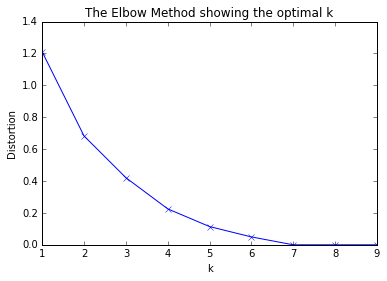

In [70]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,10)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 12)
    k_means.fit(density_parks_in_neighborhood['Density'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(density_parks_in_neighborhood['Density'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / density_parks_in_neighborhood['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### optimal value of k for parks comes out to be 5

In [71]:
num_clusters = 5

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 10)
k_means.fit(density_parks_in_neighborhood['Density'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[0 3 1 3 0 1 3 2 1 1 1 4 0 2 1 3 3 4 1 3 2 1 1 4 1 3 3]


In [72]:
density_parks_in_neighborhood['Cluster'] = k_means.labels_
density_parks_in_neighborhood.head(10)

,Neighborhood,Density,Distance,Cluster
0,"Adelaide, King, Richmond",6,150.0,0
1,"Brockton, Exhibition Place, Parkdale Village",1,703.0,3
2,Business Reply Mail Processing Centre 969 Eastern,2,423.0,1
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",1,834.0,3
4,"Cabbagetown, St. James Town",6,633.0,0
5,Central Bay Street,2,342.0,1
6,"Chinatown, Grange Park, Kensington Market",1,527.0,3
7,Christie,4,701.0,2
8,Church and Wellesley,2,471.0,1
9,Davisville,2,472.0,1


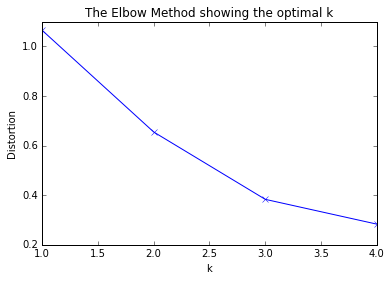

In [73]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,5)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 2)
    k_means.fit(density_clubs_in_neighborhood['Density'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(density_clubs_in_neighborhood['Density'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / density_clubs_in_neighborhood['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### optimal value of k for clubs comes out to be 2.5 but we have to take an integer value for further processing so i have taken 3 

In [74]:
num_clusters = 3

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 2)
k_means.fit(density_clubs_in_neighborhood['Density'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[0 1 2 1 1 2 1 0 2 2 2 0 0 0 2 1 1 0 2 1 0 2 2 0 2 1]


In [75]:
density_clubs_in_neighborhood['Cluster'] = k_means.labels_
density_clubs_in_neighborhood.head(10)

,Neighborhood,Density,Distance,Cluster
0,"Adelaide, King, Richmond",6,150.0,0
1,"Brockton, Exhibition Place, Parkdale Village",1,703.0,1
2,Business Reply Mail Processing Centre 969 Eastern,2,423.0,2
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",1,834.0,1
4,M5E,0,111.0,1
5,Central Bay Street,2,342.0,2
6,"Chinatown, Grange Park, Kensington Market",1,527.0,1
7,Christie,4,701.0,0
8,Church and Wellesley,2,471.0,2
9,Davisville,2,472.0,2


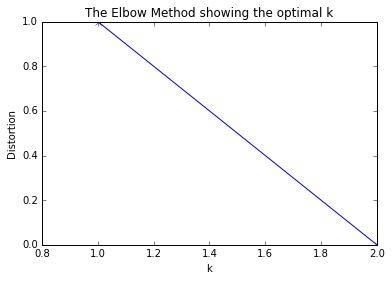

In [76]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,3)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 2)
    k_means.fit(density_malls_in_neighborhood['Density'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(density_malls_in_neighborhood['Density'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / density_malls_in_neighborhood['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### optimal value of k for malls comes out to be 1.4 but i have taken 2 for further processing as an integer

In [77]:
num_clusters = 2

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 2)
k_means.fit(density_malls_in_neighborhood['Density'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[1 0]


In [78]:
density_malls_in_neighborhood['Cluster'] = k_means.labels_
density_malls_in_neighborhood.head(10)

,Neighborhood,Density,Distance,Cluster
0,"Harbourfront East, Toronto Islands, Union Station",2,353.0,1
1,M5E,0,111.0,0


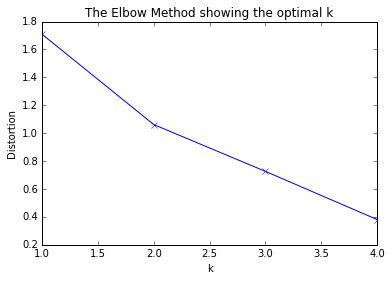

In [79]:
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
K = range(1,5)
for k in K:
    k_means = KMeans(init = "k-means++", n_clusters = k, n_init = 2)
    k_means.fit(density_gyms_in_neighborhood['Density'].values.reshape(-1, 1))
    distortions.append(sum(np.min(cdist(density_gyms_in_neighborhood['Density'].values.reshape(-1, 1),
                                        k_means.cluster_centers_, 'euclidean'), axis=1)) / density_gyms_in_neighborhood['Density'].shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### optimal value of k for gyms comes out to be 2.5 but i have taken 3 for further processingf for being integer value

In [80]:
num_clusters = 3

k_means = KMeans(init = "k-means++", n_clusters = num_clusters, n_init = 2)
k_means.fit(density_gyms_in_neighborhood['Density'].values.reshape(-1, 1))
labels = k_means.labels_

print(labels)

[0 0 0 2 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0]


In [81]:
density_gyms_in_neighborhood['Cluster'] = k_means.labels_
density_gyms_in_neighborhood.head(10)

,Neighborhood,Density,Distance,Cluster
0,"Brockton, Exhibition Place, Parkdale Village",1,703.0,0
1,"Cabbagetown, St. James Town",1,633.0,0
2,Christie,1,701.0,0
3,Church and Wellesley,4,471.0,2
4,M5E,0,111.0,0
5,Davisville,2,472.0,0
6,Davisville North,2,472.0,0
7,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",2,701.0,0
8,"Design Exchange, Toronto Dominion Centre",13,75.0,1
9,"Dovercourt Village, Dufferin",3,792.0,0



## 6. Examine clusters of all venues 

In [82]:
centroids = np.int64(round(density_restaurants_in_neighborhood.groupby('Cluster').mean()['Density']))
frecuency = density_restaurants_in_neighborhood.groupby('Cluster').count()['Neighborhood']

cluster_info1 = pd.DataFrame([np.arange(0,5), centroids, frecuency], index=['Cluster', 'Centroid','Neighborhood']).T
cluster_info1.sort_values('Centroid', inplace=True)
cluster_info1.reset_index(drop=True, inplace=True)

cluster_info1

,Cluster,Centroid,Neighborhood
0,0.0,2.0,6.0
1,NaN,8.0,4.0
2,2.0,15.0,5.0
3,NaN,22.0,7.0
4,4.0,26.0,2.0
5,1.0,34.0,2.0
6,NaN,40.0,2.0
7,NaN,47.0,2.0
8,3.0,56.0,2.0
9,NaN,62.0,1.0


### Above information of clusters and their centroids is of restaurants

### Based on the centroids of each cluster of restaurant, the cluster names can be defined as:
    
**1. "Low Density restaurants': Centroid equals to 7**
    
**2. 'Medium-Low Density restaurants': Centroid equals to 37**
    
**3. 'Very-Low Density restaurants': Centroid  equals to 52**
    
**4. 'Medium Density restaurants': Centroid  equals to 74**

**5. 'Low-Medium Density restaurants': Centroid  equals to 91**
    
**6. 'Very-Medium Density restaurants': Centroid  equals to 113**

**7. 'High Density restaurants': Centroid  equals to 142**
    
**8. 'Medium-High Density restaurants': Centroid  equals to 176**

**9. 'Very High Density restaurants' :  Centroid  equals to 225**
    
**9. 'Extreme High Density restaurants' :  Centroid  equals to 257**

In [83]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
clusters=['Low Density restaurants','Medium-Low Density restaurants','Very-Low Density restaurants','Medium Density restaurants'
          ,'Low-Medium Density restaurants', 'Very-Medium Density restaurants','High Density restaurants','Medium-High Density restaurants','Very High Density restaurants' , 'Extreme High Density restaurants']
clusters

['Low Density restaurants',
 'Medium-Low Density restaurants',
 'Very-Low Density restaurants',
 'Medium Density restaurants',
 'Low-Medium Density restaurants',
 'Very-Medium Density restaurants',
 'High Density restaurants',
 'Medium-High Density restaurants',
 'Very High Density restaurants',
 'Extreme High Density restaurants']

In [85]:
r_values=np.arange(len(clusters))
r_values

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

([<matplotlib.axis.XTick at 0x7f345c6c8d68>,
 <a list of 10 Text xticklabel objects>)

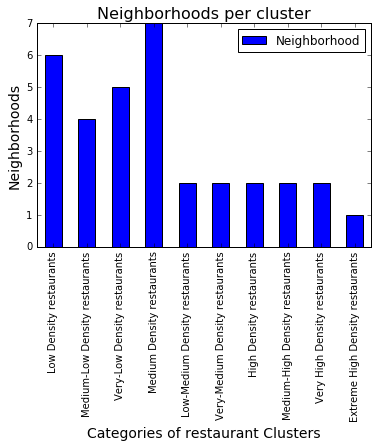

In [86]:
cluster_info1.plot(kind='bar',x='Cluster',y='Neighborhood', color='b')
plt.title("Neighborhoods per cluster", fontsize=16)
plt.xlabel("Categories of restaurant Clusters", fontsize=14)
plt.ylabel("Neighborhoods", fontsize=14)
plt.xticks(r_values, clusters)

## This plot shows that all categiries of clusters have neighborhoods and accordingly centroids are there to show  restaurant density around particular neighborhood.

### Maximum clusters are formed around very high density restaurants category area.

In [194]:
centroids = np.int64(round(density_parks_in_neighborhood.groupby('Cluster').mean()['Density']))
frecuency = density_parks_in_neighborhood.groupby('Cluster').count()['Neighborhood']

cluster_info2 = pd.DataFrame([np.arange(0,5), centroids, frecuency], index=['Cluster', 'Centroid','Neighborhood']).T
cluster_info2.sort_values('Centroid', inplace=True)
cluster_info2.reset_index(drop=True, inplace=True)

cluster_info2

,Cluster,Centroid,Neighborhood
0,0,1,9
1,3,2,11
2,1,4,6
3,4,6,1
4,2,8,1


### Above information of clusters and their centroids is of parks

### Based on the centroids of each cluster of parks, the cluster names can be defined as:
    
**1. 'Low Density parks': Centroid equals to 1**
    
**2. 'Medium-Low Density parks': Centroid  equals to 2**

**3. 'Medium-High Density parks': Centroid  equals to 4**
    
**4. 'High Density parks': Centroid  equals to 6**

**5. 'Very High Density parks':   Centroid  equals to 8**

In [195]:
clusters=['Low Density parks', 'Medium-Low Density parks', 'Medium-High Density parks', 'High Density parks','Very High Density parks']
clusters

['Low Density parks',
 'Medium-Low Density parks',
 'Medium-High Density parks',
 'High Density parks',
 'Very High Density parks']

In [196]:
p_values=np.arange(len(clusters))
p_values

array([0, 1, 2, 3, 4])

([<matplotlib.axis.XTick at 0x7eff9461e048>,
 <a list of 5 Text xticklabel objects>)

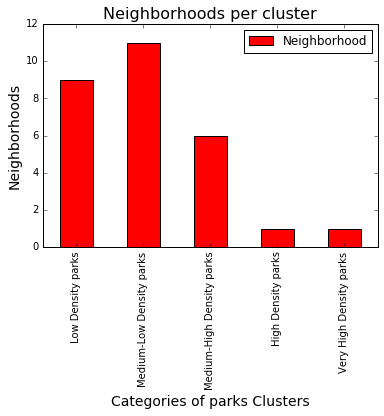

In [197]:
cluster_info2.plot(kind='bar',x='Cluster',y='Neighborhood', color='r')
plt.title("Neighborhoods per cluster", fontsize=16)
plt.xlabel("Categories of parks Clusters", fontsize=14)
plt.ylabel("Neighborhoods", fontsize=14)
plt.xticks(p_values, clusters)

## This plot shows that all categiries of clusters have neighborhoods and accordingly centroids are there to show parks density around particular neighborhood.
### Maximum clusters are formed around very high density parks category area.

In [198]:
centroids = np.int64(round(density_clubs_in_neighborhood.groupby('Cluster').mean()['Density']))
frecuency = density_clubs_in_neighborhood.groupby('Cluster').count()['Neighborhood']

cluster_info3 = pd.DataFrame([np.arange(0,5), centroids, frecuency], index=['Cluster', 'Centroid','Neighborhood']).T
cluster_info3.sort_values('Centroid', inplace=True)
cluster_info3.reset_index(drop=True, inplace=True)

cluster_info3

,Cluster,Centroid,Neighborhood
0,0.0,2.0,22.0
1,2.0,4.0,4.0
2,1.0,8.0,1.0
3,3.0,NaN,NaN
4,4.0,NaN,NaN


### Above information of clusters and their centroids is of clubs

### Based on the centroids of each cluster of clubs, the cluster names can be defined as:
    
**1. 'Low Density clubs': Centroid equals to 2**
    
**2. 'Medium-low Density clubs':  Centroid equals to 4** 
    
**3. 'Medium-high Density clubs':  Centroid equals to 8**
    
**4. 'High Density clubs': Centroid  equals to NAN**

**5. 'Very-High Density clubs': Centroid  equals to NAN**



In [199]:
clusters=['Low Density clubs', 'Medium-Low Density clubs', 'Medium-High Density clubs', 'High Density clubs','Very High Density clubs']
clusters

['Low Density clubs',
 'Medium-Low Density clubs',
 'Medium-High Density clubs',
 'High Density clubs',
 'Very High Density clubs']

In [200]:
c_values=np.arange(len(clusters))
c_values

array([0, 1, 2, 3, 4])

([<matplotlib.axis.XTick at 0x7eff9685b5f8>,
 <a list of 5 Text xticklabel objects>)

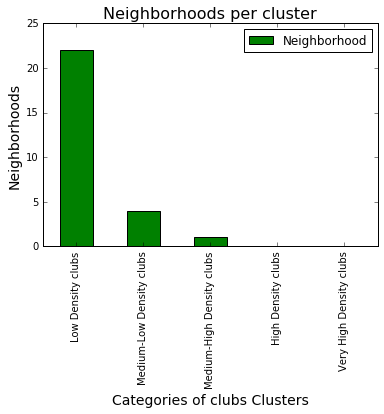

In [201]:
cluster_info3.plot(kind='bar',x='Cluster',y='Neighborhood', color='g')
plt.title("Neighborhoods per cluster", fontsize=16)
plt.xlabel("Categories of clubs Clusters", fontsize=14)
plt.ylabel("Neighborhoods", fontsize=14)
plt.xticks(p_values, clusters)

## This plot shows that all categiries of clusters have neighborhoods and accordingly centroids are there to show clubs density around particular neighborhood.
### Maximum clusters are formed around very medium-high density clubs category area beacuse other categories has null values of centroids as well as clusters.

In [202]:
centroids = np.int64(round(density_malls_in_neighborhood.groupby('Cluster').mean()['Density']))
frecuency = density_malls_in_neighborhood.groupby('Cluster').count()['Neighborhood']

cluster_info4 = pd.DataFrame([np.arange(0,5), centroids, frecuency], index=['Cluster', 'Centroid','Neighborhood']).T
cluster_info4.sort_values('Centroid', inplace=True)
cluster_info4.reset_index(drop=True, inplace=True)

cluster_info4

,Cluster,Centroid,Neighborhood
0,1.0,0.0,1.0
1,0.0,2.0,1.0
2,2.0,NaN,NaN
3,3.0,NaN,NaN
4,4.0,NaN,NaN


### Above information of clusters and their centroids is of malls

### Based on the centroids of each cluster of malls, the cluster names can be defined as:
    
**1. 'Low Density malls': Centroid equals to 0**
    
**2. 'Medium-low Density malls':  Centroid equals to 2** 
    
**3. 'Medium-high Density malls':  Centroid equals to NAN**
    
**4. 'High Density malls': Centroid  equals to NAN**

**5. 'Very-High Density malls': Centroid  equals to NAN**



In [203]:
clusters=['Low Density malls', 'Medium-Low Density malls', 'Medium-High Density malls', 'High Density malls','Very High Density malls']
clusters

['Low Density malls',
 'Medium-Low Density malls',
 'Medium-High Density malls',
 'High Density malls',
 'Very High Density malls']

In [204]:
m_values=np.arange(len(clusters))
m_values

array([0, 1, 2, 3, 4])

([<matplotlib.axis.XTick at 0x7eff943c7ac8>,
 <a list of 5 Text xticklabel objects>)

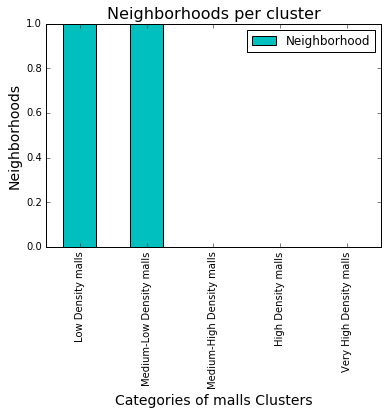

In [205]:
cluster_info4.plot(kind='bar',x='Cluster',y='Neighborhood', color="c")
plt.title("Neighborhoods per cluster", fontsize=16)
plt.xlabel("Categories of malls Clusters", fontsize=14)
plt.ylabel("Neighborhoods", fontsize=14)
plt.xticks(m_values, clusters)

## This plot shows that all categiries of clusters have neighborhoods and accordingly centroids are there to show malls density around particular neighborhood.
### Maximum clusters are formed around very medium-low density malls category area beacuse other categories has null values of centroids as well as clusters.

In [206]:
centroids = np.int64(round(density_gyms_in_neighborhood.groupby('Cluster').mean()['Density']))
frecuency = density_gyms_in_neighborhood.groupby('Cluster').count()['Neighborhood']

cluster_info5 = pd.DataFrame([np.arange(0,5), centroids, frecuency], index=['Cluster', 'Centroid','Neighborhood']).T
cluster_info5.sort_values('Centroid', inplace=True)
cluster_info5.reset_index(drop=True, inplace=True)

cluster_info5

,Cluster,Centroid,Neighborhood
0,0.0,2.0,17.0
1,2.0,5.0,3.0
2,1.0,12.0,2.0
3,3.0,NaN,NaN
4,4.0,NaN,NaN


### Above information of clusters and their centroids is of gyms

### Based on the centroids of each cluster of gyms, the cluster names can be defined as:
    
**1. 'Low Density gyms': Centroid equals to 1**
    
**2. 'Medium-low Density gyms':  Centroid equals to 5** 

**3. 'Medium-high Density gyms':  Centroid equals to 12**  

**4. 'High Density gyms': Centroid  equals to NAN**
    
**5. 'Very-High Density gyms': Centroid  equals to NAN**



In [207]:
clusters=['Low Density gyms', 'Medium-Low Density gyms', 'Medium-High Density gyms', 'High Density gyms','Very High Density gyms']
clusters

['Low Density gyms',
 'Medium-Low Density gyms',
 'Medium-High Density gyms',
 'High Density gyms',
 'Very High Density gyms']

In [208]:
g_values=np.arange(len(clusters))
g_values

array([0, 1, 2, 3, 4])

([<matplotlib.axis.XTick at 0x7eff9466e1d0>,
 <a list of 5 Text xticklabel objects>)

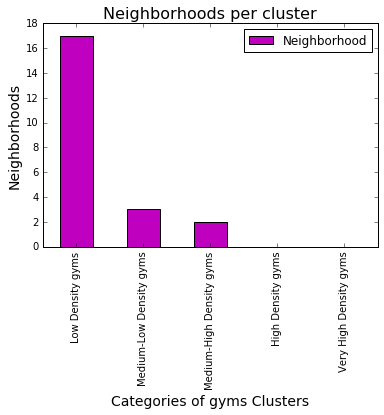

In [209]:
cluster_info5.plot(kind='bar',x='Cluster',y='Neighborhood', color="m")
plt.title("Neighborhoods per cluster", fontsize=16)
plt.xlabel("Categories of gyms Clusters", fontsize=14)
plt.ylabel("Neighborhoods", fontsize=14)
plt.xticks(m_values, clusters)

## This plot shows that all categiries of clusters have neighborhoods and accordingly centroids are there to show gyms density around particular neighborhood.
### Maximum clusters are formed around very medium-high density gyms category area beacuse other categories has null values of centroids as well as clusters.

# All above graphs shows that there are many no. of restaurants & parks in neighborhoods of toronto but clubs, malls, gyms are less comparatively in those areas. So anyone could take decision while acquiring accommadation accordingly by analyzing this data analysis.

### Now it's time to plot a Choropleth maps to show all these types of venues on a map and their clusters.

### To plot these maps first we have to  add latitudes and longitudes of neighborhoods & then take venues count in table . After all this done, map will be drawn with highlighted points with different colours showing all information

### 1. Restaurants 
### 2. Parks
### 3. Clubs
### 4. Malls
### 5. Gyms

## Restaurant
### adding latitude and longitude of neighborhoods

In [132]:
count_restaurants_in_neighborhood = density_restaurants_in_neighborhood.join(postcodes_with_coordinates_df.set_index('Neighborhood'), on='Neighborhood')

count_restaurants_in_neighborhood.head(10)

,Neighborhood,Density_x,Distance_x,Cluster_x,Density_y,Distance_y,Cluster_y,Postcode,Borough,Latitude,Longitude
0,"Adelaide, King, Richmond",26,150.0,4,6,150.0,0,M5H,Downtown Toronto,43.650571,-79.384568
1,"Brockton, Exhibition Place, Parkdale Village",21,703.0,7,1,703.0,3,M6K,West Toronto,43.636847,-79.428191
2,Business Reply Mail Processing Centre 969 Eastern,4,423.0,0,2,423.0,1,M7Y,East Toronto,43.662744,-79.321558
3,"Cabbagetown, St. James Town",23,633.0,7,6,633.0,0,M4X,Downtown Toronto,43.667967,-79.367675
4,Central Bay Street,49,342.0,8,2,342.0,1,M5G,Downtown Toronto,43.657952,-79.387383
5,"Chinatown, Grange Park, Kensington Market",62,527.0,6,1,527.0,3,M5T,Downtown Toronto,43.653206,-79.400049
6,Christie,4,701.0,0,4,701.0,2,M6G,Downtown Toronto,43.669542,-79.422564
7,Church and Wellesley,55,471.0,3,2,471.0,1,M4Y,Downtown Toronto,43.665860,-79.383160
8,Davisville,21,472.0,7,2,472.0,1,M4S,Central Toronto,43.704324,-79.388790
9,"Dovercourt Village, Dufferin",3,792.0,0,3,792.0,4,M6H,West Toronto,43.669005,-79.442259


In [134]:
count_restaurants_in_neighborhood = count_restaurants_in_neighborhood[['Neighborhood','Latitude','Longitude','Density_x']]
count_restaurants_in_neighborhood.columns = ['Neighborhood','Latitude','Longitude','Restaurant Count']
count_restaurants_in_neighborhood.fillna(0, inplace = True)
count_restaurants_in_neighborhood

,Neighborhood,Latitude,Longitude,Restaurant Count
0,"Adelaide, King, Richmond",43.650571,-79.384568,26
1,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,21
2,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,4
3,"Cabbagetown, St. James Town",43.667967,-79.367675,23
4,Central Bay Street,43.657952,-79.387383,49
5,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,62
6,Christie,43.669542,-79.422564,4
7,Church and Wellesley,43.665860,-79.383160,55
8,Davisville,43.704324,-79.388790,21
9,"Dovercourt Village, Dufferin",43.669005,-79.442259,3


## Park
### adding latitude and longitude of neighborhoods

In [145]:
count_parks_in_neighborhood = density_parks_in_neighborhood.join(postcodes_with_coordinates_df.set_index('Neighborhood'), on='Neighborhood')

count_parks_in_neighborhood.head()

,Neighborhood,Density,Distance,Cluster,Postcode,Borough,Latitude,Longitude
0,"Adelaide, King, Richmond",6,150.0,0,M5H,Downtown Toronto,43.650571,-79.384568
1,"Brockton, Exhibition Place, Parkdale Village",1,703.0,3,M6K,West Toronto,43.636847,-79.428191
2,Business Reply Mail Processing Centre 969 Eastern,2,423.0,1,M7Y,East Toronto,43.662744,-79.321558
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",1,834.0,3,M5V,Downtown Toronto,43.628947,-79.394420
4,"Cabbagetown, St. James Town",6,633.0,0,M4X,Downtown Toronto,43.667967,-79.367675


In [146]:
count_parks_in_neighborhood = count_parks_in_neighborhood[['Neighborhood','Latitude','Longitude','Density']]
count_parks_in_neighborhood.columns = ['Neighborhood','Latitude','Longitude','park Count']
count_parks_in_neighborhood.fillna(0, inplace = True)
count_parks_in_neighborhood

,Neighborhood,Latitude,Longitude,park Count
0,"Adelaide, King, Richmond",43.650571,-79.384568,6
1,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,1
2,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,2
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420,1
4,"Cabbagetown, St. James Town",43.667967,-79.367675,6
5,Central Bay Street,43.657952,-79.387383,2
6,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,1
7,Christie,43.669542,-79.422564,4
8,Church and Wellesley,43.665860,-79.383160,2
9,Davisville,43.704324,-79.388790,2


## Club
### adding latitude and longitude of neighborhoods

In [147]:
count_clubs_in_neighborhood = density_clubs_in_neighborhood.join(postcodes_with_coordinates_df.set_index('Neighborhood'), on='Neighborhood')

count_clubs_in_neighborhood.head()

,Neighborhood,Density,Distance,Cluster,Postcode,Borough,Latitude,Longitude
0,"Adelaide, King, Richmond",6,150.0,0,M5H,Downtown Toronto,43.650571,-79.384568
1,"Brockton, Exhibition Place, Parkdale Village",1,703.0,1,M6K,West Toronto,43.636847,-79.428191
2,Business Reply Mail Processing Centre 969 Eastern,2,423.0,2,M7Y,East Toronto,43.662744,-79.321558
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",1,834.0,1,M5V,Downtown Toronto,43.628947,-79.394420
4,M5E,0,111.0,1,NaN,NaN,NaN,NaN


In [148]:
count_clubs_in_neighborhood = count_clubs_in_neighborhood[['Neighborhood','Latitude','Longitude','Density']]
count_clubs_in_neighborhood.columns = ['Neighborhood','Latitude','Longitude','club Count']
count_clubs_in_neighborhood.fillna(0, inplace = True)
count_clubs_in_neighborhood

,Neighborhood,Latitude,Longitude,club Count
0,"Adelaide, King, Richmond",43.650571,-79.384568,6
1,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,1
2,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,2
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420,1
4,M5E,0.000000,0.000000,0
5,Central Bay Street,43.657952,-79.387383,2
6,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,1
7,Christie,43.669542,-79.422564,4
8,Church and Wellesley,43.665860,-79.383160,2
9,Davisville,43.704324,-79.388790,2


## Mall
### adding latitude and longitude of neighborhoods

In [149]:
count_malls_in_neighborhood = density_malls_in_neighborhood.join(postcodes_with_coordinates_df.set_index('Neighborhood'), on='Neighborhood')

count_malls_in_neighborhood.head()

,Neighborhood,Density,Distance,Cluster,Postcode,Borough,Latitude,Longitude
0,"Harbourfront East, Toronto Islands, Union Station",2,353.0,1,M5J,Downtown Toronto,43.640816,-79.381752
1,M5E,0,111.0,0,NaN,NaN,NaN,NaN


In [150]:
count_malls_in_neighborhood = count_malls_in_neighborhood[['Neighborhood','Latitude','Longitude','Density']]
count_malls_in_neighborhood.columns = ['Neighborhood','Latitude','Longitude','malls Count']
count_malls_in_neighborhood.fillna(0, inplace = True)
count_malls_in_neighborhood

,Neighborhood,Latitude,Longitude,malls Count
0,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,2
1,M5E,0.000000,0.000000,0


## Gyms
### adding latitude and longitude of neighborhoods

In [151]:
count_gyms_in_neighborhood = density_gyms_in_neighborhood.join(postcodes_with_coordinates_df.set_index('Neighborhood'), on='Neighborhood')

count_gyms_in_neighborhood.head()

,Neighborhood,Density,Distance,Cluster,Postcode,Borough,Latitude,Longitude
0,"Brockton, Exhibition Place, Parkdale Village",1,703.0,0,M6K,West Toronto,43.636847,-79.428191
1,"Cabbagetown, St. James Town",1,633.0,0,M4X,Downtown Toronto,43.667967,-79.367675
2,Christie,1,701.0,0,M6G,Downtown Toronto,43.669542,-79.422564
3,Church and Wellesley,4,471.0,2,M4Y,Downtown Toronto,43.665860,-79.383160
4,M5E,0,111.0,0,NaN,NaN,NaN,NaN


In [152]:
count_gyms_in_neighborhood = count_gyms_in_neighborhood[['Neighborhood','Latitude','Longitude','Density']]
count_gyms_in_neighborhood.columns = ['Neighborhood','Latitude','Longitude','gyms Count']
count_gyms_in_neighborhood.fillna(0, inplace = True)
count_gyms_in_neighborhood

,Neighborhood,Latitude,Longitude,gyms Count
0,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,1
1,"Cabbagetown, St. James Town",43.667967,-79.367675,1
2,Christie,43.669542,-79.422564,1
3,Church and Wellesley,43.665860,-79.383160,4
4,M5E,0.000000,0.000000,0
5,Davisville,43.704324,-79.388790,2
6,Davisville North,43.712751,-79.390197,2
7,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,2
8,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,13
9,"Dovercourt Village, Dufferin",43.669005,-79.442259,3


##  7. Cluster Neighborhoods for all 5 types of venues one by one.

### 7.1 Clustering of restaurant

In [135]:
# set number of clusters
kclusters = 11

count_restaurants_in_neighborhood_clustering = count_restaurants_in_neighborhood.drop(['Neighborhood', 'Latitude', 'Longitude'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(count_restaurants_in_neighborhood_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([ 2, 10,  4,  2,  1,  5,  4,  9, 10,  4], dtype=int32)

In [136]:
# add clustering labels
count_restaurants_in_neighborhood['Cluster Labels'] = kmeans.labels_

count_restaurants_in_neighborhood.sort_values('Cluster Labels') # check the last columns!

,Neighborhood,Latitude,Longitude,Restaurant Count,Cluster Labels
19,"The Annex, North Midtown, Yorkville",43.672710,-79.405678,11,0
4,Central Bay Street,43.657952,-79.387383,49,1
10,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,45,1
0,"Adelaide, King, Richmond",43.650571,-79.384568,26,2
3,"Cabbagetown, St. James Town",43.667967,-79.367675,23,2
18,Studio District,43.659526,-79.340923,23,2
21,"The Danforth West, Riverdale",43.679557,-79.352188,35,3
2,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,4,4
6,Christie,43.669542,-79.422564,4,4
9,"Dovercourt Village, Dufferin",43.669005,-79.442259,3,4


### Choropleth map of Toronto for restaurants

In [137]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(count_restaurants_in_neighborhood['Latitude'],count_restaurants_in_neighborhood['Longitude'], count_restaurants_in_neighborhood['Neighborhood'], count_restaurants_in_neighborhood['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 7.2 Clustering of parks

In [157]:
# set number of clusters
kclusters = 10

count_parks_in_neighborhood_clustering = count_parks_in_neighborhood.drop(['Neighborhood', 'Latitude', 'Longitude'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(count_parks_in_neighborhood_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 9, 4, 9, 3, 4, 9, 6, 4, 4], dtype=int32)

In [155]:
# add clustering labels
count_parks_in_neighborhood['Cluster Labels'] = kmeans.labels_

count_parks_in_neighborhood.sort_values('Cluster Labels') # check the last columns!

,Neighborhood,Latitude,Longitude,park Count,Cluster Labels
12,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,5,0
1,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,1,1
15,Lawrence Park,43.728020,-79.388790,1,1
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.394420,1,1
25,"The Danforth West, Riverdale",43.679557,-79.352188,1,1
6,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,1,1
16,"Little Portugal, Trinity",43.647927,-79.419750,1,1
19,"Parkdale, Roncesvalles",43.648960,-79.456325,1,1
10,Davisville North,43.712751,-79.390197,2,2
14,"High Park, The Junction South",43.661608,-79.464763,2,2


### Choropleth map of Toronto for parks

In [156]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(count_parks_in_neighborhood['Latitude'],count_parks_in_neighborhood['Longitude'], count_parks_in_neighborhood['Neighborhood'], count_parks_in_neighborhood['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 7.3 Clustering of clubs

In [159]:
# set number of clusters
kclusters = 10

count_clubs_in_neighborhood_clustering = count_clubs_in_neighborhood.drop(['Neighborhood', 'Latitude', 'Longitude'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(count_clubs_in_neighborhood_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([6, 2, 1, 2, 5, 1, 2, 3, 1, 1], dtype=int32)

In [160]:
# add clustering labels
count_clubs_in_neighborhood['Cluster Labels'] = kmeans.labels_

count_clubs_in_neighborhood.sort_values('Cluster Labels') # check the last columns!

,Neighborhood,Latitude,Longitude,club Count,Cluster Labels
12,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,5,0
22,Studio District,43.659526,-79.340923,2,1
2,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558,2,1
21,"Runnymede, Swansea",43.651571,-79.484450,2,1
5,Central Bay Street,43.657952,-79.387383,2,1
18,North Toronto West,43.715383,-79.405678,2,1
8,Church and Wellesley,43.665860,-79.383160,2,1
9,Davisville,43.704324,-79.388790,2,1
10,Davisville North,43.712751,-79.390197,2,1
24,The Beaches,43.676357,-79.293031,2,1


### Choropleth map of Toronto for clubs

In [161]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(count_clubs_in_neighborhood['Latitude'],count_clubs_in_neighborhood['Longitude'], count_clubs_in_neighborhood['Neighborhood'], count_clubs_in_neighborhood['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 7.3 Clustering of malls

In [167]:
# set number of clusters
kclusters = 2

count_malls_in_neighborhood_clustering = count_malls_in_neighborhood.drop(['Neighborhood', 'Latitude', 'Longitude'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(count_malls_in_neighborhood_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1], dtype=int32)

In [168]:
# add clustering labels
count_malls_in_neighborhood['Cluster Labels'] = kmeans.labels_

count_malls_in_neighborhood.sort_values('Cluster Labels') # check the last columns!

,Neighborhood,Latitude,Longitude,malls Count,Cluster Labels
0,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,2,0
1,M5E,0.000000,0.000000,0,1


### Choropleth map of Toronto for malls

In [169]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(count_malls_in_neighborhood['Latitude'],count_malls_in_neighborhood['Longitude'], count_malls_in_neighborhood['Neighborhood'], count_malls_in_neighborhood['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 7.3 Clustering of gyms

In [170]:
# set number of clusters
kclusters = 10

count_gyms_in_neighborhood_clustering = count_gyms_in_neighborhood.drop(['Neighborhood', 'Latitude', 'Longitude'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(count_gyms_in_neighborhood_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 4, 4, 3, 6, 0, 0, 0, 1, 5], dtype=int32)

In [171]:
# add clustering labels
count_gyms_in_neighborhood['Cluster Labels'] = kmeans.labels_

count_gyms_in_neighborhood.sort_values('Cluster Labels') # check the last columns!

,Neighborhood,Latitude,Longitude,gyms Count,Cluster Labels
18,North Toronto West,43.715383,-79.405678,2,0
5,Davisville,43.704324,-79.388790,2,0
6,Davisville North,43.712751,-79.390197,2,0
7,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,2,0
22,"The Beaches West, India Bazaar",43.668999,-79.315572,2,0
12,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,2,0
8,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,13,1
11,"Harbord, University of Toronto",43.662696,-79.400049,7,2
3,Church and Wellesley,43.665860,-79.383160,4,3
19,"Runnymede, Swansea",43.651571,-79.484450,1,4


### Choropleth map of Toronto for gyms

In [172]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(count_gyms_in_neighborhood['Latitude'],count_gyms_in_neighborhood['Longitude'], count_gyms_in_neighborhood['Neighborhood'], count_gyms_in_neighborhood['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Conclusion:
# Highlights in map are showing different types of venues(i.e. restaurants, parks, clubs, malls, gyms) on map with their respective clusters and densities in all different maps separately.
# Cluster number shown on each point represents cluster category(like low density, medium density or high density) which is different for each type of venue and can be seen through bar plots as made above.


# FUTURE INSIGHTS

# As we know People are turning to big cities to start a business or  for service purpose or for any other work.. For this reason, people can achieve better outcomes through their access to the platforms where such information is provided.

# 1. For investors: Real estate investors who want to invest in properties could get better idea of property prices by observing this venues data near by.
# 2. For immigrants: People coming from different areas, suburbs, or different countries could find an accommodation in an easy way by using this data analysis according to their priorities.
# 3. Management purpose: City managers can manage the city more regularly by using similar data analysis types or platforms.
# 4. Citizens prospective: Citizens who already lived there could also check out this data analysis for shifting/relocating purpose  within Toronto.
# 5. Social prospective: Venues density in particular area could decide measure of pollution, noise or crime also.
